In [1]:
import sys
#Indicate operating environment and import core modules
location_input = input("what computer are you on? a = Bens, b = gpucluster, c = other   ")
location_dict = {'a': "C:\\Users\\heine\\github\\expression_broad_data", 'b': "/home/heineike/github/expression_broad_data",'c':'you need to add your location to the location_dict'}
base_dir = location_dict[location_input]
print("base directory is " + base_dir)

if sys.path[-1] != base_dir:
    sys.path.append(base_dir)
    print("Added " + base_dir + " to path: " )
    print(sys.path)
import os

print("I am about to import a library")
from core import expression_plots 
from core import io_library 
%load_ext autoreload
%autoreload 2
# %matplotlib 
# plt.ioff()
%matplotlib inline
#%matplotlib notebook
data_processing_dir = base_dir + os.sep + os.path.normpath("expression_data") + os.sep
from matplotlib_venn import venn2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
# from sklearn import linear_model
# import pickle
# import subprocess
# import networkx as nx
import scipy.stats as stats
import statsmodels.graphics.gofplots as stats_graph

import scipy.cluster.hierarchy as sch
#from sklearn.cluster import AgglomerativeClustering

# from Bio import SeqIO
# from Bio import SeqFeature as sf
# from Bio.Alphabet import generic_dna
# from Bio.Seq import Seq

# import re

from collections import Counter
# import scipy.stats as stats
# from itertools import chain
#this only works if you are online
online_input = input("are you online? Yes/No")
if online_input == "Yes": 
    import plotly.plotly as py
    import plotly.graph_objs as pygo
    import plotly.tools as pytools
    py.sign_in('heineike02_student','9dMTMZgJMgUP0YX0P5mQ')
    #py.sign_in('heineike02', 'APPjKrtARaN2ZgUYIkqr')

what computer are you on? a = Bens, b = gpucluster, c = other   a
base directory is C:\Users\heine\github\expression_broad_data
Added C:\Users\heine\github\expression_broad_data to path: 
['', 'C:\\Users\\heine\\Anaconda3\\python36.zip', 'C:\\Users\\heine\\Anaconda3\\DLLs', 'C:\\Users\\heine\\Anaconda3\\lib', 'C:\\Users\\heine\\Anaconda3', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\Babel-2.5.0-py3.6.egg', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\heine\\.ipython', 'C:\\Users\\heine\\github\\expression_broad_data']
I am about to import a library
I am importing io_library
what computer are you on? a = Bens, b = gpucluster, c = other   a
base directory is C:\Users\heine\github\expression_broad_data
data process

# Plot KL LFC alongside KL Expression data from regev. 

In [3]:

# Load KL DE Seq Data
kl_nmpp1_lfc = pd.read_pickle(base_dir + "\expression_data\kl_PKA_as_20160824\LFC_KLac_ASmin_ASplus.pkl")
# drop padj (not used for this analysis)
kl_nmpp1_lfc.drop('padj',axis=1, inplace=True) 



In [16]:
#Reload KL microarry data from Regev lab. 

#had to update growth data file after noticing an error
#only need to do this once
species_list = ['Kluyveromyces lactis', 'Saccharomyces cerevisiae']
fname_out_bases = ['KLac', 'SCer']
base_dir = 'C:\Users\Ben\Documents\GitHub\expression_broad_data'

io_library.make_data_tables(species_list,fname_out_bases, base_dir)

C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\raw_exp\KLac_raw_exp.csv saved


core\io_library.py:200: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  expdata = expdata.sort()


All ID's match between experiment data and orf lookup table. Species = Kluyveromyces lactis, Experiment Type = Growth
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE36253_Growth\KLac_growth.csv saved
All ID's match between experiment data and orf lookup table. Species = Kluyveromyces lactis, Experiment Type = Stress
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE38478_Stress\KLac_stress.csv saved
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\raw_exp\SCer_raw_exp.csv saved
All ID's match between experiment data and orf lookup table. Species = Saccharomyces cerevisiae, Experiment Type = Growth
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE36253_Growth\SCer_growth.csv saved
All ID's match between experiment data and orf lookup table. Species = Saccharomyces cerevisiae, Experiment Type = Stress
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE38478_Stress\SCer_stress.csv sav

In [4]:
#Reload KL microarry data from Regev lab. cont
#Import KL ESR data

# This is the regev raw expression
#   1) It might be interesting to plot it v.s. the RNA seq level data (but counts is not gene expression)
#   2) It would be good to integrate the data into the big dataframe
# #Load raw expression data
# species = 'KLac'
# fname = os.path.normpath(base_dir + "\expression_data\\raw_exp\\"  + species + '_raw_exp.csv')
# raw_exp = pd.read_csv(fname, index_col = 'orf_name')
# print fname + ' raw expression dataset loaded'
# #extract mean expression only
# mean_gene_expression = raw_exp['Mean']
# mean_gene_expression.name = 'mean_gene_expression'

#Load data for microarrays
species = 'KLac'

fname = os.path.normpath(base_dir + "\expression_data\\GSE36253_Growth\\"  + species + '_growth.csv' )
growth_exp = pd.read_csv(fname,header = [0,1,2], index_col = [0,1])
print fname + ' growth microarray dataset loaded'

#group by conditions and take mean
growth_replicate_groups = growth_exp.groupby(axis = 1, level = 'conditions')
growth_exp_avg = growth_replicate_groups.aggregate(np.mean)

fname = os.path.normpath(base_dir + "\expression_data\\GSE38478_Stress\\"  + species + '_stress.csv' )
stress_exp = pd.read_csv(fname,header = [0,1,2], index_col = [0,1])
print fname + ' stress microarray dataset loaded'

#group by condition and take mean
stress_replicate_groups = stress_exp.groupby(axis = 1, level = 'conditions')
stress_exp_avg = stress_replicate_groups.aggregate(np.mean)

#combine growth and stress average expression datasets. 
if False in stress_exp_avg.index==growth_exp_avg.index:
    print "Error: ID mismatch between condition data. Species = {}".format(species)
condition_arrays = pd.concat([growth_exp_avg,stress_exp_avg], axis = 1)

#gets rid of ID index
condition_arrays.reset_index(level=0, inplace=True)

C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE36253_Growth\KLac_growth.csv growth microarray dataset loaded
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE38478_Stress\KLac_stress.csv stress microarray dataset loaded


In [10]:
#Hsp12 is this: KLLA0D07634g
condition_arrays.loc['KLLA0D07634g']



conditions
ID                       14544.000000
DS/LOG                       6.833094
LAG/LOG                      1.265305
LL/LOG                       4.109909
PLAT/LOG                     4.047119
PS/LOG                       6.456386
NaCl_005                     2.400802
NaCl_015                     0.460518
NaCl_030                     1.342152
NaCl_060                     0.279167
heat shock_005               8.199017
heat shock_015                    NaN
heat shock_030                    NaN
heat shock_045               8.880749
heat shock_060               9.297101
hydrogen peroxide_005        2.764462
hydrogen peroxide_015        5.596948
hydrogen peroxide_030        9.452556
hydrogen peroxide_060        3.368526
Name: KLLA0D07634g, dtype: float64

In [5]:
#Join Regev data to Log fold change from KL PKA inhibition experiment

kl_stress_nmpp1_data = kl_nmpp1_lfc.join(condition_arrays, on = 'orf_name') 
kl_stress_nmpp1_data.drop('ID', axis=1, inplace=True)
kl_stress_nmpp1_data.set_index('orf_name',inplace = True)

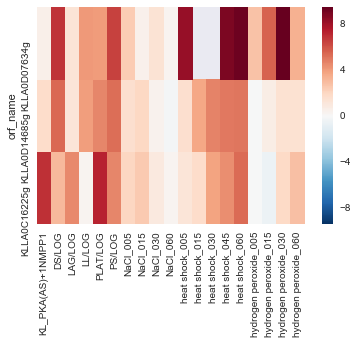

In [7]:
subset = kl_stress_nmpp1_data.loc[['KLLA0D07634g','KLLA0D14685g','KLLA0C16225g']]
sns.heatmap(subset)
#KLLA0C16225g

Hsp12 - middle gene is very low under PKA inhibition in KL, but still heavily induced for heat shock and oxidative stress. 
What other genes are low for PKA inhibition, but high for heat shock? 

In [10]:
kl_stress_nmpp1_data_pka_not_act = kl_stress_nmpp1_data[kl_stress_nmpp1_data['KL_PKA(AS)+1NMPP1']<2.0]
kl_stress_nmpp1_data_pka_not_act_high_heat = kl_stress_nmpp1_data_pka_not_act[kl_stress_nmpp1_data_pka_not_act['heat shock_045']>2.0]
kl_stress_nmpp1_data_pka_not_act_high_heat_sorted = kl_stress_nmpp1_data_pka_not_act_high_heat.sort_values(by='heat shock_045', ascending=False)

In [8]:
#Read in kl_sc_data to see what SC PKA inhibition looks like
kl_sc_PKA_data_motif_hits = pd.read_pickle(base_dir + "\expression_data\kl_PKA_as_20160824\kl_sc_PKA_data_motif_hits")

In [22]:
kl_sc_PKA_data_motif_hits[kl_sc_PKA_data_motif_hits['SC_common_name'].isin(['RPL2A','RPL2B','HSP12','CTT1','SIP18'])].transpose()

,1073,2220,4500,4768,4769
N SCer Orthologs,1,1,2,2,2
kl_genename,KLLA0D07634g,KLLA0D14685g,KLLA0C16225g,KLLA0D16027g,KLLA0D16027g
sc_genename,YFL014W,YGR088W,YMR175W,YFR031C-A,YIL018W
KL_PKA(AS)+1NMPP1,0.581167,1.7331,6.91127,-6.91637,-6.91637
padj,4.34147e-37,5.34357e-190,0,0,0
SC_PKA(AS)+1NMPP1,8.10995,6.86678,7.66036,-5.16534,-4.17221
SC_common_name,HSP12,CTT1,SIP18,RPL2A,RPL2B
kl_msn2_hits,0,0,2,3,3
sc_msn2_hits,7,4,3,4,0
kl_hsf1_hits,1,0,0,0,0


In [11]:
kl_sc_PKA_data_motif_hits[kl_sc_PKA_data_motif_hits['kl_genename'].isin(['KLLA0D07634g','KLLA0D14685g','KLLA0C16225g'])]

,N SCer Orthologs,kl_genename,sc_genename,KL_PKA(AS)+1NMPP1,padj,SC_PKA(AS)+1NMPP1,SC_common_name,kl_msn2_hits,sc_msn2_hits,kl_hsf1_hits,...,kl_hap3_hits,sc_hap3_hits,kl_cat8_hits,sc_cat8_hits,kl_rap1_hits,sc_rap1_hits,kl_AAGGGA_hits,sc_AAGGGA_hits,kl_hac1_hits,sc_hac1_hits
1073,1,KLLA0D07634g,YFL014W,0.581167,4.341468e-37,8.10995,HSP12,0,7,1,...,0,0,0,2,0,1,1,0,0,0
2220,1,KLLA0D14685g,YGR088W,1.733099,5.343571e-190,6.86678,CTT1,0,4,0,...,0,0,0,0,0,0,0,0,0,0
4500,2,KLLA0C16225g,YMR175W,6.911274,0.000000e+00,7.66036,SIP18,2,3,0,...,0,1,0,0,0,0,0,2,0,0
4501,2,KLLA0C16225g,YPL223C,6.911274,0.000000e+00,5.50555,GRE1,2,0,0,...,0,0,0,0,0,1,0,4,0,0


In [17]:
#set(list(kl_stress_nmpp1_data_pka_not_act_high_heat_sorted.index))
kl_sc_PKA_data_low_klPKA_high_klHeat = kl_sc_PKA_data_motif_hits[kl_sc_PKA_data_motif_hits['kl_genename'].isin(kl_stress_nmpp1_data_pka_not_act_high_heat_sorted.index)]
kl_sc_PKA_data_low_klPKA_high_klHeat.sort_values(by = 'SC_PKA(AS)+1NMPP1',ascending=False)

,N SCer Orthologs,kl_genename,sc_genename,KL_PKA(AS)+1NMPP1,padj,SC_PKA(AS)+1NMPP1,SC_common_name,kl_msn2_hits,sc_msn2_hits,kl_hsf1_hits,...,kl_hap3_hits,sc_hap3_hits,kl_cat8_hits,sc_cat8_hits,kl_rap1_hits,sc_rap1_hits,kl_AAGGGA_hits,sc_AAGGGA_hits,kl_hac1_hits,sc_hac1_hits
1073,1,KLLA0D07634g,YFL014W,0.581167,4.341468e-37,8.109950,HSP12,0,7,1,...,0,0,0,2,0,1,1,0,0,0
2220,1,KLLA0D14685g,YGR088W,1.733099,5.343571e-190,6.866780,CTT1,0,4,0,...,0,0,0,0,0,0,0,0,0,0
2607,1,KLLA0F00528g,YAL061W,1.872165,1.209971e-162,3.948590,BDH2,1,3,0,...,0,2,0,0,0,0,0,1,0,0
399,1,KLLA0F06226g,YML004C,1.411776,8.115291e-184,3.092360,GLO1,1,2,0,...,1,0,0,0,0,0,1,1,0,0
3618,1,KLLA0B11880g,YIR017C,1.792734,4.371209e-115,2.858100,MET28,2,1,0,...,0,0,0,0,0,0,0,0,0,1
1758,1,KLLA0F05775g,YDL124W,1.962376,9.963739e-143,2.714280,YDL124W,1,2,0,...,0,0,0,1,1,0,1,0,0,1
2167,1,KLLA0F20009g,YLR109W,1.753788,0.000000e+00,2.581580,AHP1,1,3,0,...,1,0,0,1,0,0,0,2,0,0
1615,1,KLLA0F13574g,YKL103C,1.633552,1.268377e-123,2.542640,APE1,2,2,0,...,0,0,0,0,0,0,0,1,0,0
1841,1,KLLA0F01881g,YJL066C,1.070835,7.937278e-55,2.322330,MPM1,0,2,0,...,0,0,1,0,0,0,0,0,0,0
3002,1,KLLA0A07535g,YOL110W,1.456494,3.605030e-15,2.257130,SHR5,0,1,0,...,0,0,0,1,0,0,2,0,0,0


In [23]:
condition_arrays_SC.loc[['YGR088W','YFL014W','YMR175W']]

conditions,ID,DS/LOG,LAG/LOG,LL/LOG,PLAT/LOG,PS/LOG,NaCl_005,NaCl_015,NaCl_030,NaCl_060,heat shock_005,heat shock_015,heat shock_030,heat shock_045,heat shock_060,hydrogen peroxide_005,hydrogen peroxide_015,hydrogen peroxide_030,hydrogen peroxide_060
orf_name,,,,,,,,,,,,,,,,,,,
YGR088W,A_06_P3308,6.725258,0.966313,2.525097,7.817688,9.063755,6.758664,9.321750,8.630686,6.919316,5.617417,7.308456,4.550260,6.244503,2.015708,-0.062414,-0.024651,2.965997,2.489211
YFL014W,A_06_P2839,7.896686,2.915504,0.846873,10.702357,11.416275,0.047152,13.212663,13.287712,9.323696,10.046851,9.544164,12.395761,10.483180,NaN,4.469798,1.447357,2.559604,1.328499
YMR175W,A_06_P5612,4.555804,3.693164,0.228108,10.636373,10.004353,0.686061,7.402295,8.088970,7.464446,0.000000,2.379034,3.592418,2.469237,1.023898,-0.250017,-0.007817,0.067477,0.797742


[6, 7, 0, 10, 11, 12, 13, 14, 3, 4, 1, 5, 15, 18, 16, 17, 2, 8, 9]
[0, 3, 4, 1, 5, 11, 12, 13, 14, 6, 7, 18, 17, 16, 15, 8, 9, 2]


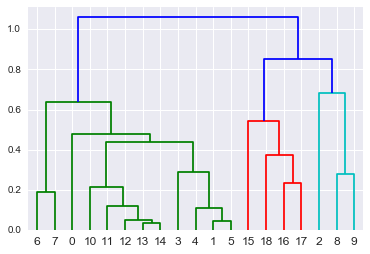

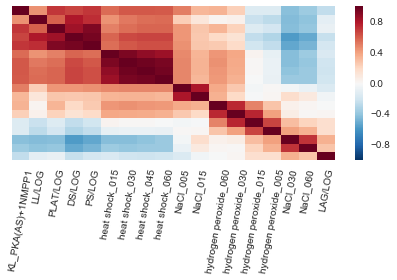

In [19]:
#Correlation heatmap with all conditions v.s. PKA inhibition. 

#First do heirarchical clustering of conditions, then reorder matrix. 
kl_stress_nmpp1_data_nanrm = kl_stress_nmpp1_data.fillna(0.0)
kl_stress_nmpp1_data_transpose = kl_stress_nmpp1_data_nanrm.as_matrix().transpose()
col_cluster = sch.linkage(kl_stress_nmpp1_data_transpose, method='average', metric = 'correlation')
col_dend = sch.dendrogram(col_cluster)
col_ind_reorder = col_dend['leaves']
#new columns look almost right but need to flip the tree around.  
print col_ind_reorder
col_ind_reorder_pretty = [0,3,4,1,5,11,12,13,14,6,7,18,17,16,15,8,9,2]
print col_ind_reorder_pretty

# col_ind_reorder_branch_flip ={16 : 19, 19: 18, 18:16}
# col_ind_reorder_pretty = col_ind_reorder[:]  #Need to use slice because otherwise the two lists are linked.  This makes a copy
# for key in col_ind_reorder_branch_flip.keys():
#     ind_ind = col_ind_reorder.index(key)
#     col_ind_reorder_pretty[ind_ind] = col_ind_reorder_branch_flip[key]

old_cols = kl_stress_nmpp1_data.columns.tolist()
new_cols = [old_cols[ind] for ind in col_ind_reorder_pretty]



kl_stress_nmpp1_data_col_reorder = kl_stress_nmpp1_data[new_cols]

#Plot correlation Matrix
#corr = kl_stress_nmpp1_data.corr()
corr = kl_stress_nmpp1_data_col_reorder.corr()
fig2, ax = plt.subplots()
ax = sns.heatmap(corr)
ax.tick_params(axis='y',labelleft = 'off')
plt.setp(ax.get_xticklabels(), rotation = 80)
plt.tight_layout()
plt.savefig('C:\Users\Ben\Google Drive\UCSF\ElSamad_Lab\Lab Meeting\\20161118\KL_corr.png')
#Clean up labels


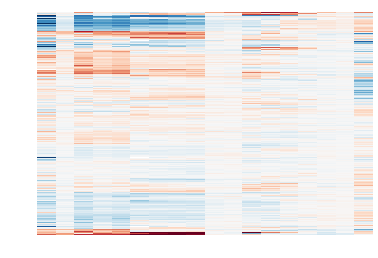

In [26]:
#Heirarchical cluster of genes with columns ordered as above to visualise ESR genes. 

#First filter out items with mostly NA values. 
kl_stress_nmpp1_data_filt = kl_stress_nmpp1_data_col_reorder.dropna(thresh=(len(kl_stress_nmpp1_data_col_reorder.columns)-1))

#Drop out PKA column for clustering
kl_stress_data = kl_stress_nmpp1_data_filt.drop('KL_PKA(AS)+1NMPP1', axis = 1)

kl_stress_data_nafill = kl_stress_data.fillna(0.0)
kl_stress_data_mat = kl_stress_data_nafill.as_matrix()

#fig3, ax_cm = plt.subplots()
#ax_cm = sns.clustermap(kl_stress_data_col_reorder_nafill,colcluster = False)
#ax_cm.ax_heatmap.tick_params(labelleft = 'off')

row_cluster = sch.linkage(kl_stress_data_mat, method='average')
row_ind_reorder = sch.leaves_list(row_cluster)

old_rows = kl_stress_nmpp1_data_filt.index.tolist()
new_rows = [old_rows[ind] for ind in row_ind_reorder]

kl_stress_nmpp1_data_filt_reorder = kl_stress_nmpp1_data_filt.reindex(new_rows)

fig3, ax3 = plt.subplots()
#ax3= sns.heatmap(kl_stress_nmpp1_data_filt_reorder)
# ax3 = plt.imshow(kl_stress_nmpp1_data_filt_reorder.as_matrix(), cmap='RdBu', vmin=z_min, vmax=z_max,
#            extent=[x.min(), x.max(), y.min(), y.max()],
#            interpolation='nearest', origin='lower')
ax3 = plt.imshow(-kl_stress_nmpp1_data_filt_reorder.as_matrix(), interpolation="nearest", aspect = 'auto', cmap = 'RdBu',vmin = -6, vmax = 6)
plt.axis('off')
plt.savefig('C:\Users\Ben\Google Drive\UCSF\ElSamad_Lab\Lab Meeting\\20161118\KL_genes.png')


# SC PKA inhibition data alongside SC Expression data from regev ordering the columns as determined by KL clustering above. 

In [12]:
#Load oshea PKA inhibition data

oshea_SC_PKA_data = io_library.load_oshea_NMPP1_data()


In [5]:
#Import Regev data for SCer
#Load data for microarrays
species = 'SCer'

fname = os.path.normpath(data_processing_dir + "GSE36253_Growth\\"  + species + '_growth.csv' )
growth_exp = pd.read_csv(fname,header = [0,1,2], index_col = [0,1])
print(fname + ' growth microarray dataset loaded')

#group by conditions and take mean
growth_replicate_groups = growth_exp.groupby(axis = 1, level = 'conditions')
growth_exp_avg = growth_replicate_groups.aggregate(np.mean)

fname = os.path.normpath(data_processing_dir + "GSE38478_Stress\\"  + species + '_stress.csv' )
stress_exp = pd.read_csv(fname,header = [0,1,2], index_col = [0,1])
print(fname + ' stress microarray dataset loaded')

#group by condition and take mean
stress_replicate_groups = stress_exp.groupby(axis = 1, level = 'conditions')
stress_exp_avg = stress_replicate_groups.aggregate(np.mean)

#combine growth and stress average expression datasets. 
if False in stress_exp_avg.index==growth_exp_avg.index:
    print("Error: ID mismatch between condition data. Species = {}".format(species))
condition_arrays_SC = pd.concat([growth_exp_avg,stress_exp_avg], axis = 1)

#gets rid of ID index
condition_arrays_SC.reset_index(level=0, inplace=True)


C:\Users\heine\github\expression_broad_data\expression_data\GSE36253_Growth\SCer_growth.csv growth microarray dataset loaded
C:\Users\heine\github\expression_broad_data\expression_data\GSE38478_Stress\SCer_stress.csv stress microarray dataset loaded


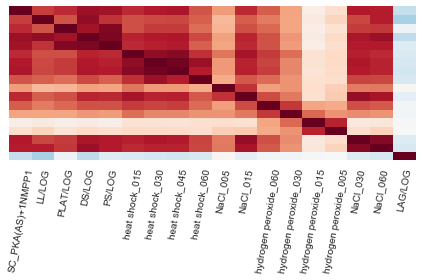

In [20]:
#Using same condition ordering as in KL dataset, look at SCer condition clustering. 

#Merge NMPP1 and Condition Data
sc_stress_nmpp1_data = pd.merge(oshea_SC_PKA_data, condition_arrays_SC, how='inner', left_index=True, right_index=True)
sc_stress_nmpp1_data.drop(['ID', 'SC_common_name'], axis=1, inplace=True)

#Reorder columns 
old_cols = sc_stress_nmpp1_data.columns.tolist()
new_cols = [old_cols[ind] for ind in col_ind_reorder_pretty]

sc_stress_nmpp1_data_col_reorder = sc_stress_nmpp1_data[new_cols]

#Plot correlation Matrix
corr = sc_stress_nmpp1_data_col_reorder.corr()
fig2, ax = plt.subplots()
ax = sns.heatmap(corr, cbar = False)
ax.tick_params(axis='y',labelleft = 'off')
plt.setp(ax.get_xticklabels(), rotation = 80)
plt.tight_layout()
plt.savefig('C:\Users\Ben\Google Drive\UCSF\ElSamad_Lab\Lab Meeting\\20161118\SC_corr.png')


In [23]:
#Cleans up SC NMPP1/Stress data to cluster genes

#Filter out columns that have mostly NA values. 
sc_stress_nmpp1_data_filt = sc_stress_nmpp1_data_col_reorder.dropna(thresh=(len(sc_stress_nmpp1_data_col_reorder.columns)-1))

#Combine rows that have duplicate values. 
gene_names = sc_stress_nmpp1_data_filt.index.tolist()
print len(gene_names)
print len(set(gene_names))

#This shows you which genes have duplicates 
# frequency = Counter(gene_names)
# frequency.most_common()[:20]

#Builds a dictionary that gives index values in the original dataframe for each genename 
gene_names_to_inds = defaultdict(list)
for ind, value in enumerate(gene_names):
    gene_names_to_inds[value].append(ind)

# gene_names_to_inds['YNR077C']

# #Build new dataframe, averaging duplicate indices
sc_stress_nmpp1_data_consolidated_list = []
col_names = sc_stress_nmpp1_data_filt.columns
Ncols = len(col_names)
for gene_name, inds in gene_names_to_inds.iteritems():
    if len(inds) == 1:
        sc_stress_nmpp1_data_consolidated_list.append((gene_name,sc_stress_nmpp1_data_filt.iloc[inds[0],:]))
    else: 
        exp_values_no_zeros = []
        repeat_data = sc_stress_nmpp1_data_filt.iloc[inds]
        for col_name in col_names:
            exp_values_no_zeros.append([val for val in repeat_data[col_name] if val !=0])

        exp_values_avg = []
        for val in exp_values_no_zeros:
            if len(val)==0:
                exp_values_avg.append(0.0)
            else:
                exp_values_avg.append(np.mean(val))
        
        exp_values_avg_series = pd.Series(exp_values_avg, index =col_names)
        sc_stress_nmpp1_data_consolidated_list.append((gene_name,exp_values_avg_series))

sc_stress_nmpp1_data_consolidated = pd.DataFrame.from_items(sc_stress_nmpp1_data_consolidated_list , orient='index', columns=col_names)


6212
6184


clustering
plotting


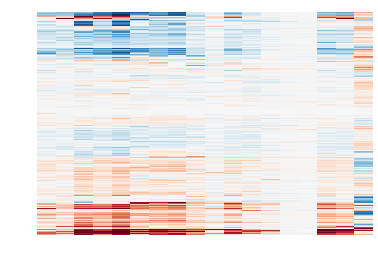

In [25]:
#Heirarchical cluster of genes with columns ordered as above to visualise ESR genes.

#drop out AS data for clustering
sc_stress_data = sc_stress_nmpp1_data_consolidated.drop(['SC_PKA(AS)+1NMPP1'], axis = 1)

sc_stress_data_nafill = sc_stress_data.fillna(0.0)
sc_stress_data_mat = sc_stress_data_nafill.as_matrix()

print 'clustering'
row_cluster = sch.linkage(sc_stress_data_mat, method='average')
row_ind_reorder = sch.leaves_list(row_cluster)

old_rows = sc_stress_nmpp1_data_consolidated.index.tolist()
new_rows = [old_rows[ind] for ind in row_ind_reorder]

sc_stress_nmpp1_data_reorder = sc_stress_nmpp1_data_consolidated.reindex(new_rows)

print 'plotting'
fig3, ax3 = plt.subplots()
#ax3= sns.heatmap(kl_stress_nmpp1_data_filt_reorder)
# ax3 = plt.imshow(kl_stress_nmpp1_data_filt_reorder.as_matrix(), cmap='RdBu', vmin=z_min, vmax=z_max,
#            extent=[x.min(), x.max(), y.min(), y.max()],
#            interpolation='nearest', origin='lower')
ax3 = plt.imshow(-sc_stress_nmpp1_data_reorder.as_matrix(), interpolation="nearest", aspect = 'auto', cmap = 'RdBu',vmin = -6, vmax = 6)
plt.axis('off')
plt.savefig('C:\Users\Ben\Google Drive\UCSF\ElSamad_Lab\Lab Meeting\\20161118\SC_genes.png')


## Compare PKA expression 

In [2]:
#Load my data
pka_inh_YPD_t40 = pd.read_csv(data_processing_dir + os.path.normpath("20170817_klscpka/20170817_klscpka_DESEQ_YPD_t40_AsMinvAsPlus_SC.csv"))
pka_inh_YPD_t40.rename(columns={'Unnamed: 0':'sc_genename','log2FoldChange': 'PKA_inh_YPD_t40'}, inplace=True )

pka_inh_SDC_t40 = pd.read_csv(data_processing_dir + os.path.normpath("20170817_klscpka/20170817_klscpka_DESEQ_SDC_t40_AsMinvAsPlus_SC.csv"))
pka_inh_SDC_t40.rename(columns={'Unnamed: 0':'sc_genename','log2FoldChange': 'PKA_inh_SDC_t40'}, inplace=True )

#Load Gasch Data
fig1_gasch_conditions = io_library.all_gasch_conditions("gasch_fig1_all_conditions.txt")
gasch_data = io_library.read_gasch_data(fig1_gasch_conditions,"gasch_fig1_all_conditions.txt")

#Load Regev Data
regev_data = io_library.combine_growth_stress_datasets('SCer')
regev_data.drop('ID', axis = 1, inplace=True)
#give data a suffix of _reg to distinguish from Gasch data
regev_data.rename(columns = dict(zip(regev_data.columns, [column + '_reg' for column in regev_data.columns])),inplace=True)

#Load pronk data
pronk_data = pd.read_table(data_processing_dir+os.path.normpath('Tai_2005_data/2010.Tai05.filter.flt.knn.avg.div.log.pcl'))   #2010.Causton01_acid.filter.flt.knn.avg.div.log.pcl'))
#get rid of first row

experiments = ['glucose', 'nitrogen','sulfur','phosphorus']

experiment_sets = {}
for experiment in experiments:
    experiment_sets[experiment] = [column for column in pronk_data.columns if experiment in column.split(' ')]

conditions = ['Aerobic', 'Anaerobic']
for experiment in experiments:
    for condition in conditions: 
        #extract condition columns, average
        condition_columns =  [column for column in experiment_sets[experiment] if condition in column.split(' ')]
        pronk_data[experiment + '_' + condition] = pronk_data.loc[:,condition_columns].mean(axis=1)
    #subtract anaerobic average from average - also convert to log(2)
    pronk_data[experiment + '_Aerobic_vs_Anaerobic'] = np.log(10)/np.log(2) * (pronk_data[experiment + '_Aerobic']-pronk_data[experiment + '_Anaerobic'])


C:\Users\heine\github\expression_broad_data\expression_data\regev_data\GSE36253_Growth\SCer_growth.csv growth microarray dataset loaded
C:\Users\heine\github\expression_broad_data\expression_data\regev_data\GSE38478_Stress\SCer_stress.csv stress microarray dataset loaded
combined dataset saved as C:\Users\heine\github\expression_broad_data\expression_data\regev_data\SCer_growth_stress.csv


In [2]:
#Load Causton Data
causton_data = pd.read_table(data_processing_dir+os.path.normpath('causton_2001_data/causton_2001.txt'))   #2010.Causton01_acid.filter.flt.knn.avg.div.log.pcl'))
columns_to_keep = [name for name in list(causton_data.columns) if name.split(':')[0] != 'Call']
causton_data = causton_data.loc[:,columns_to_keep]
#Make fold change dataset - take average 0 minute data.  Divide every condition by that data.  Take Log base2. 

causton_data[causton_data['ORF']=='YOR273C']

,ORF,Gene,Heat 0' (A),Heat 0' (B),Heat 15',Heat 30',Heat 45',Heat 60',Heat 120',Acid 0' (A),...,NaCl 30',NaCl 45',NaCl 60',NaCl 120',Sorbitol 0',Sorbitol 15',Sorbitol 30',Sorbitol 45',Sorbitol 90',Sorbitol 120'
5577,YOR273C,YOR273C,193.8,89.7,279.3,230.4,20.0,118.9,81.3,215.1,...,8702.5,5519.6,1604.8,1475.5,630.0,4382.0,3081.1,1475.0,746.0,1080.2


In [5]:
causton_data.columns

Index(['ORF', 'Gene', 'Heat 0' (A)', 'Heat 0' (B)', 'Heat 15'', 'Heat 30'',
       'Heat 45'', 'Heat 60'', 'Heat 120'', 'Acid 0' (A)', 'Acid 0' (B)',
       'Acid 10'', 'Acid 20'', 'Acid 40'', 'Acid 60'', 'Acid 80'', 'Acid 100'',
       'Alkali 0' (A)', 'Alkali 0' (B)', 'Alkali 10'', 'Alkali 20'',
       'Alkali 40'', 'Alkali 60'', 'Alkali 80'', 'Alkali 100'',
       'msn2/4 acid 0'', 'msn2/4 acid 10'', 'msn2/4 acid 20'',
       'Peroxide 0' (A)', 'Peroxide 0' (B)', 'Peroxide 10'', 'Peroxide 20'',
       'Peroxide 40'', 'Peroxide 60'', 'Peroxide 120'', 'NaCl 0'', 'NaCl 15'',
       'NaCl 30'', 'NaCl 45'', 'NaCl 60'', 'NaCl 120'', 'Sorbitol 0'',
       'Sorbitol 15'', 'Sorbitol 30'', 'Sorbitol 45'', 'Sorbitol 90'',
       'Sorbitol 120''],
      dtype='object')

In [12]:
experiment = 'Heat'
causton_data.loc[:,experiment_sets[experiment]]

#extract 0' columns
experiment_sets[experiment]
#average them (if there is more than 1)

#divide other columns by them

#take log2

#add new columns back to original data

,Heat 0' (A),Heat 0' (B),Heat 15',Heat 30',Heat 45',Heat 60',Heat 120'
0,126.0,114.6,127.9,208.2,178.4,85.6,59.3
1,54.0,42.0,70.2,112.9,151.7,106.8,117.8
2,9651.0,7004.0,7530.4,7286.2,7129.0,7351.7,6468.4
3,30.0,33.6,101.3,158.6,54.7,35.9,120.3
4,1816.0,1394.8,4185.5,6146.8,4823.2,4233.3,5565.6
5,406.0,318.5,585.6,870.9,1098.9,593.8,686.7
6,82.0,94.7,457.7,436.9,470.0,304.7,472.9
7,112.0,77.2,215.9,138.2,221.3,221.9,192.6
8,77.0,63.4,120.5,82.7,124.3,129.8,176.3
9,224.0,126.0,227.0,308.5,177.7,223.7,199.1


In [8]:
experiments = ['Heat', 'Acid','Alkali', 'Peroxide', 'NaCl', 'Sorbitol', 'msn2/4']

experiment_sets = {}
for experiment in experiments:
    experiment_sets[experiment] = [column for column in causton_data.columns if experiment in column.split(' ')]

experiment_sets

{'Acid': ["Acid 0' (A)",
  "Acid 0' (B)",
  "Acid 10'",
  "Acid 20'",
  "Acid 40'",
  "Acid 60'",
  "Acid 80'",
  "Acid 100'"],
 'Alkali': ["Alkali 0' (A)",
  "Alkali 0' (B)",
  "Alkali 10'",
  "Alkali 20'",
  "Alkali 40'",
  "Alkali 60'",
  "Alkali 80'",
  "Alkali 100'"],
 'Heat': ["Heat 0' (A)",
  "Heat 0' (B)",
  "Heat 15'",
  "Heat 30'",
  "Heat 45'",
  "Heat 60'",
  "Heat 120'"],
 'NaCl': ["NaCl 0'",
  "NaCl 15'",
  "NaCl 30'",
  "NaCl 45'",
  "NaCl 60'",
  "NaCl 120'"],
 'Peroxide': ["Peroxide 0' (A)",
  "Peroxide 0' (B)",
  "Peroxide 10'",
  "Peroxide 20'",
  "Peroxide 40'",
  "Peroxide 60'",
  "Peroxide 120'"],
 'Sorbitol': ["Sorbitol 0'",
  "Sorbitol 15'",
  "Sorbitol 30'",
  "Sorbitol 45'",
  "Sorbitol 90'",
  "Sorbitol 120'"],
 'msn2/4': ["msn2/4 acid 0'", "msn2/4 acid 10'", "msn2/4 acid 20'"]}

In [3]:
#Merge data
compiled_exp_data = pka_inh_YPD_t40.loc[:,['sc_genename','PKA_inh_YPD_t40']].merge(pka_inh_SDC_t40.loc[:,['sc_genename','PKA_inh_SDC_t40']],on='sc_genename', how = 'left')

#Merge Gasch Data
compiled_exp_data = compiled_exp_data.merge(gasch_data, how = 'left', left_on='sc_genename', right_index=True)

#Merge Regev Data
compiled_exp_data = compiled_exp_data.merge(regev_data, how = 'left', left_on= 'sc_genename', right_index = True)

#Merge pronk data
columns_to_keep = [experiment + '_Aerobic_vs_Anaerobic' for experiment in ['glucose', 'nitrogen','sulfur','phosphorus']]
columns_to_keep = ['YORF'] + columns_to_keep
pronk_data_subset = pronk_data.loc[:,columns_to_keep]
pronk_data_subset.rename(columns = {'YORF':'sc_genename'}, inplace = True)
compiled_exp_data = compiled_exp_data.merge(pronk_data_subset, how = 'left', on = 'sc_genename')


In [4]:
#cluster columns based on correlation. 

#remove all columns that have NANs for my data. 
compiled_exp_data_nanrm = compiled_exp_data[~compiled_exp_data['PKA_inh_YPD_t40'].isna()]

#remove all columns that are filled with NANs 
data_columns = compiled_exp_data.columns
data_columns = data_columns.drop('sc_genename')
external_data_columns = data_columns[2:]
ind_to_remove = []
for ind, row in compiled_exp_data_nanrm.iterrows():
    #compiled_exp_data[compiled_exp_data['sc_genename']=='YNR034W-A']
    N_nas = (sum(row[external_data_columns].isna().values))
    if N_nas == len(external_data_columns):
        ind_to_remove.append(ind)
compiled_exp_data_nanrm = compiled_exp_data_nanrm.drop(ind_to_remove)

#fill the rest of the NAs with 0's
compiled_exp_data_nanrm = compiled_exp_data_nanrm.fillna(0.0) 

#remove sc_genename column and transpose
compiled_exp_data_transpose = compiled_exp_data_nanrm.drop('sc_genename', axis = 1).as_matrix().transpose()
corr_mat = np.corrcoef(compiled_exp_data_transpose)

col_cluster = sch.linkage(compiled_exp_data_transpose, method='average', metric = 'correlation')
col_dend = sch.dendrogram(col_cluster, no_plot=True)
col_ind_reorder = col_dend['leaves']

corr_mat_clustered = np.corrcoef(compiled_exp_data_transpose[col_ind_reorder])

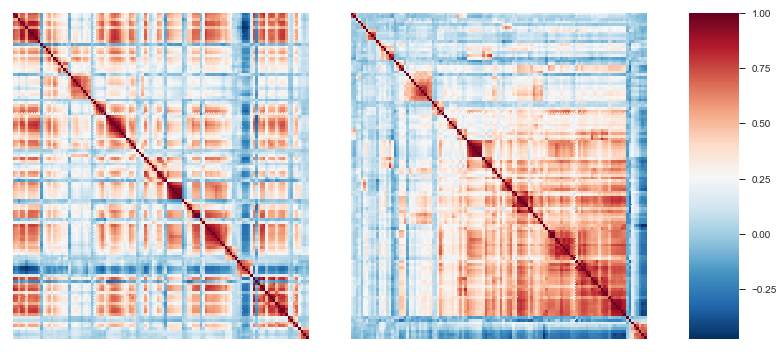

In [60]:
fig, axarr = plt.subplots(1,3,gridspec_kw = {'width_ratios':[6,6, 1]})
ax0 = axarr[0]
sns.heatmap(corr_mat, cmap="RdBu_r", ax = ax0, cbar = False, xticklabels=False, yticklabels=False)

ax1 = axarr[1]
sns.heatmap(corr_mat_clustered, cmap="RdBu_r", ax = ax1, xticklabels=False, yticklabels=False, cbar_ax = axarr[2])

fig.set_figheight(6/1)
fig.set_figwidth(13/1)

In [6]:
clustered_dataset_list = list(data_columns[col_ind_reorder])
print("My data's index is " + str(clustered_dataset_list.index('PKA_inh_YPD_t40')))
print("The visual cluster around it is from index 89 to 108 and includes")
print(clustered_dataset_list[89:108])
print("it also looks well correlated with items 66:69")
print(clustered_dataset_list[66:69])




My data's index is 93
The visual cluster around it is from index 89 to 108 and includes
['LL/LOG_reg', 'PLAT/LOG_reg', 'DS/LOG_reg', 'PS/LOG_reg', 'PKA_inh_YPD_t40', 'PKA_inh_SDC_t40', 'NaCl_015_reg', 'NaCl_030_reg', 'NaCl_060_reg', 'heat shock_060_reg', 'heat shock_015_reg', 'heat shock_030_reg', 'heat shock_045_reg', 'heat shock 33 to 37, 20 minutes', 'heat shock 29 to 37, 20 minutes', 'heat shock 17 to 37, 20 minutes', 'heat shock 21 to 37, 20 minutes', 'heat shock 25 to 37, 20 minutes', 'Heat Shock 015 minutes']
it also looks well correlated with items 66:69
['1.5 mM diamide (20 min)', '1.5 mM diamide (30 min)', '1.5 mM diamide (40 min)']


In [11]:
#could also just sort by my columns values
PKA_inh_YPD_t40_corr = pd.Series(corr_mat[0], index=data_columns)
PKA_inh_YPD_t40_corr.sort_values()

steady state 25 dec C             -0.307378
steady state 21 dec C             -0.300007
steady state 29 dec C             -0.226365
LAG/LOG_reg                       -0.197128
heat shock 37 to 37, 20 minutes   -0.137024
Nitrogen Depletion 4 h            -0.096005
1 mM Menadione (10 min)redo       -0.088968
diauxic shift timecourse 0h       -0.057740
YPD 2 h                           -0.056248
steady state 17 dec C             -0.051452
dtt 015 min                       -0.010106
diauxic shift timecourse 9p5h      0.013964
sulfur_Aerobic_vs_Anaerobic        0.023513
1M sorbitol - 60 min               0.031048
steady state 15 dec C              0.043317
YP fructose vs YPD                 0.055533
aa starv 2 h                       0.067468
hydrogen peroxide_015_reg          0.073416
YP sucrose vs YPD                  0.082890
phosphorus_Aerobic_vs_Anaerobic    0.100233
1M sorbitol - 90 min               0.105593
nitrogen_Aerobic_vs_Anaerobic      0.107981
1 mM Menadione (80 min) redo    

In [ ]:
#most correlated - my SDC data, post diauxic shift regev, heatshock45 regev, NACL30 min, 1.5mM diamide(20 min)
#uncorrelated - Nitrogen Depletion 2 h , aa starv 1h, dtt 030 min

In [107]:
PKA_inh_YPD_t40_corr[conditions_to_compare]

PKA_inh_SDC_t40                0.880365
PS/LOG_reg                     0.842931
heat shock_045_reg             0.754815
NaCl_030_reg                   0.761356
1.5 mM diamide (20 min)        0.677087
Nitrogen Depletion 2 h         0.196647
aa starv 1 h                   0.370790
dtt 030 min                    0.210056
steady state 21 dec C         -0.300007
sulfur_Aerobic_vs_Anaerobic    0.023513
YP fructose vs YPD             0.055533
dtype: float64

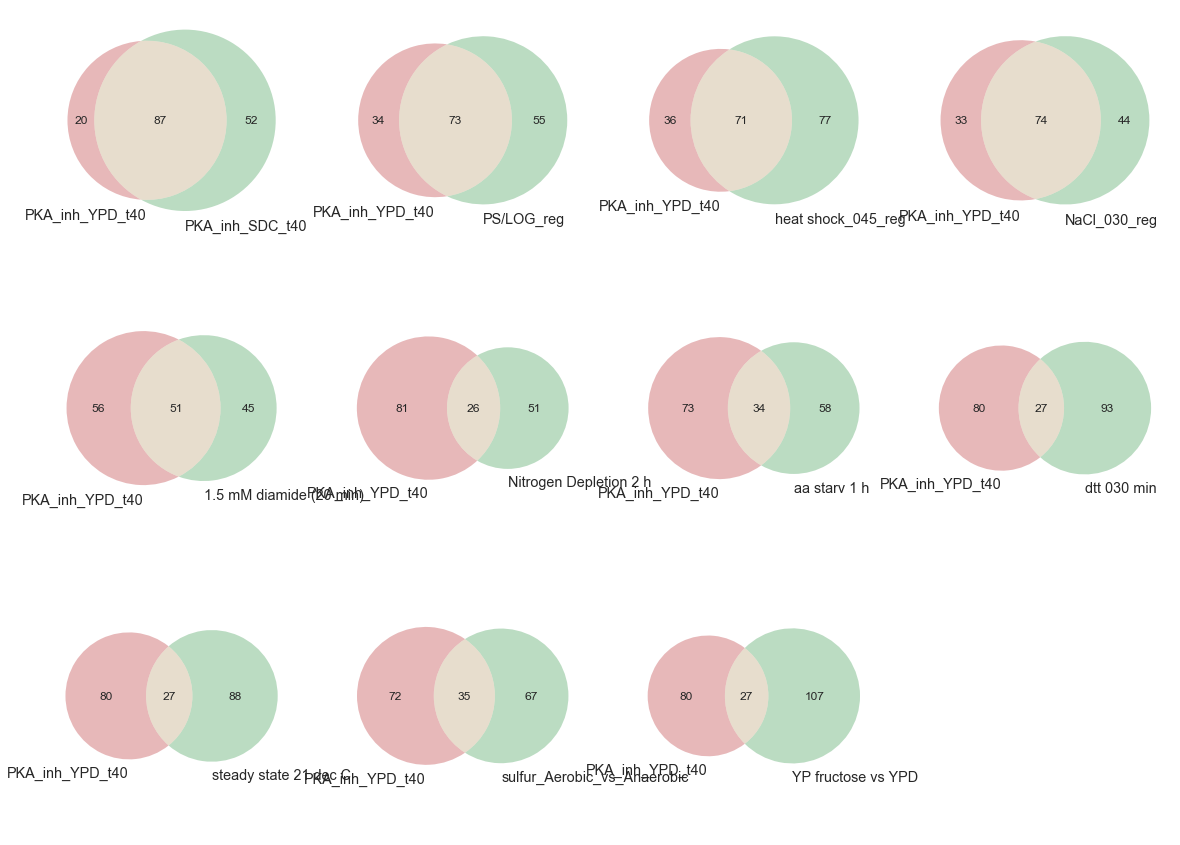

In [106]:
#Show the overlap of differentially expressed genes between various conditions -
#does it correlate with nearness to PKA inhibition. 
#Conditions to compare: 'PKA_inh_YPD_t40
conditions_to_compare = ['PKA_inh_SDC_t40','PS/LOG_reg', 'heat shock_045_reg', 'NaCl_030_reg', '1.5 mM diamide (20 min)', 
                         'Nitrogen Depletion 2 h' , 'aa starv 1 h', 'dtt 030 min', 
                         'steady state 21 dec C', 'sulfur_Aerobic_vs_Anaerobic', 'YP fructose vs YPD']

#Show normal dist superimposed and QQ plot for various options

#Assumption LFC is normally distributed. 

cutoff = 1.5   #make my cutoff for differential expression 1.5 std deviations. 

#Load orthologs
# ohnologs_expression_sorted = pd.read_csv(data_processing_dir + os.path.normpath('20170817_klscpka/20170817_ohnologs_sorted.csv'))
ohnologs = pd.read_csv(data_processing_dir + os.path.normpath("ortholog_files_YGOB/ohnologs.csv"))

#For my data
base_condition = 'PKA_inh_YPD_t40'
base_data = compiled_exp_data_nanrm[base_condition]
base_mean = base_data.mean()
base_std = base_data.std()
base_data_shift = (base_data-base_mean)/base_std
# plt.hist(base_data_shift,bins=100)

fig, axarr = plt.subplots(3,4)

#For a given gene expression dataset, 

for ind, comp_condition in enumerate(conditions_to_compare): 
    ax = axarr.flatten()[ind]
    comp_data = compiled_exp_data_nanrm[comp_condition]
    comp_mean = comp_data.mean()
    comp_std = comp_data.std()
    comp_data_shift = (comp_data-comp_mean)/comp_std

    #output differentially expressed paralogs. 
    data_comparison_full = pd.DataFrame(compiled_exp_data_nanrm['sc_genename'])
    data_comparison_full['base'] = base_data_shift
    data_comparison_full['comp'] = comp_data_shift
    data_comparisons = {}

    for ortholog_set in ['Gene 1', 'Gene 2']: 
        data_comparison = data_comparison_full[compiled_exp_data_nanrm['sc_genename'].isin(ohnologs[ortholog_set])].copy()  
        for cond in ['base','comp']: 
             data_comparison[cond+ '_levels'] =  io_library.threshold_group_KL_series(data_comparison[cond],cutoff,-cutoff)
        data_comparisons[ortholog_set] = data_comparison
        columns = data_comparison.columns
        column_rename = {column: column + '_' + ortholog_set for column in columns[1:]}
        data_comparison.rename(column_rename, axis=1, inplace=True)

    ohnologs_g1 = ohnologs.merge(data_comparisons['Gene 1'], left_on='Gene 1', right_on = 'sc_genename', how='inner')
    ohnologs_g1.drop('sc_genename', axis = 1, inplace = True)
    ohnologs_g12 = ohnologs_g1.merge(data_comparisons['Gene 2'], left_on='Gene 2', right_on = 'sc_genename', how='inner')
    ohnologs_g12.drop('sc_genename', axis = 1, inplace=True)

    for cond in ['base','comp']: 
        diff_exp = []
        for ind, row in ohnologs_g12.loc[:,[cond + '_levels_Gene 1',cond + '_levels_Gene 2']].iterrows():
            diff_exp.append(row[cond + '_levels_Gene 1'] != row[cond + '_levels_Gene 2'])
        ohnologs_g12['diff_exp_' + cond] = diff_exp

    base_diff_genes = set(ohnologs_g12[ohnologs_g12['diff_exp_base']]['Gene 1'])
    comp_diff_genes = set(ohnologs_g12[ohnologs_g12['diff_exp_comp']]['Gene 1'])
    venn2([base_diff_genes, comp_diff_genes], set_labels = (base_condition, comp_condition), ax=ax)

axarr[2,3].axis("off")
fig.set_figheight(15)
fig.set_figwidth(20)
fig.savefig(os.path.normpath('C:\\Users\heine\Google Drive\\UCSF\ElSamad_Lab\Lab Meeting\\20180209\diff_exp_venn.svg'),format='svg')

In [ ]:
#Show normal dist superimposed and QQ plot for various options

#Assumption LFC is normally distributed. 

#For a given gene expression dataset, output differentially expressed paralogs. 

#heat shock
#
#Sum data for set of experiments

In [5]:
compiled_exp_data.columns

Index(['sc_genename', 'PKA_inh_YPD_t40', 'PKA_inh_SDC_t40',
       'Heat Shock 005 minutes', 'Heat Shock 015 minutes',
       'Heat Shock 030 minutes', 'Heat Shock 060 minutes',
       'heat shock 17 to 37, 20 minutes', 'heat shock 21 to 37, 20 minutes',
       'heat shock 25 to 37, 20 minutes',
       ...
       'heat shock_045_reg', 'heat shock_060_reg', 'hydrogen peroxide_005_reg',
       'hydrogen peroxide_015_reg', 'hydrogen peroxide_030_reg',
       'hydrogen peroxide_060_reg', 'glucose_Aerobic_vs_Anaerobic',
       'nitrogen_Aerobic_vs_Anaerobic', 'sulfur_Aerobic_vs_Anaerobic',
       'phosphorus_Aerobic_vs_Anaerobic'],
      dtype='object', length=118)

<IPython.core.display.Javascript object>


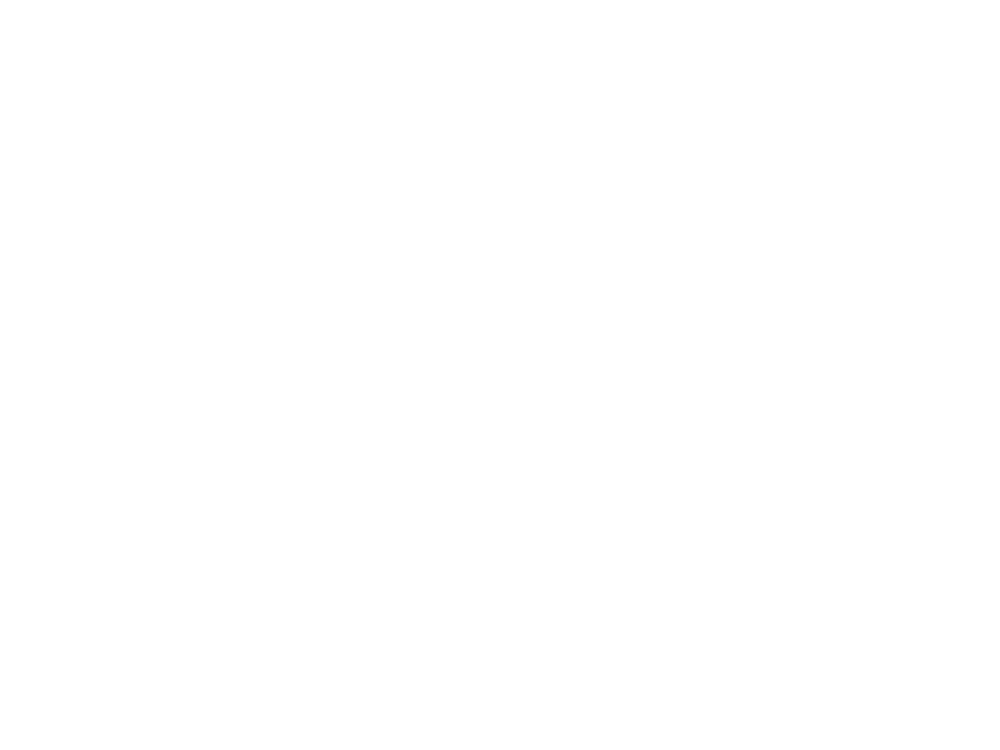

ValueError: max must be larger than min in range parameter.

In [38]:
plt.hist(compiled_exp_data['heat shock_015_reg'])

<IPython.core.display.Javascript object>


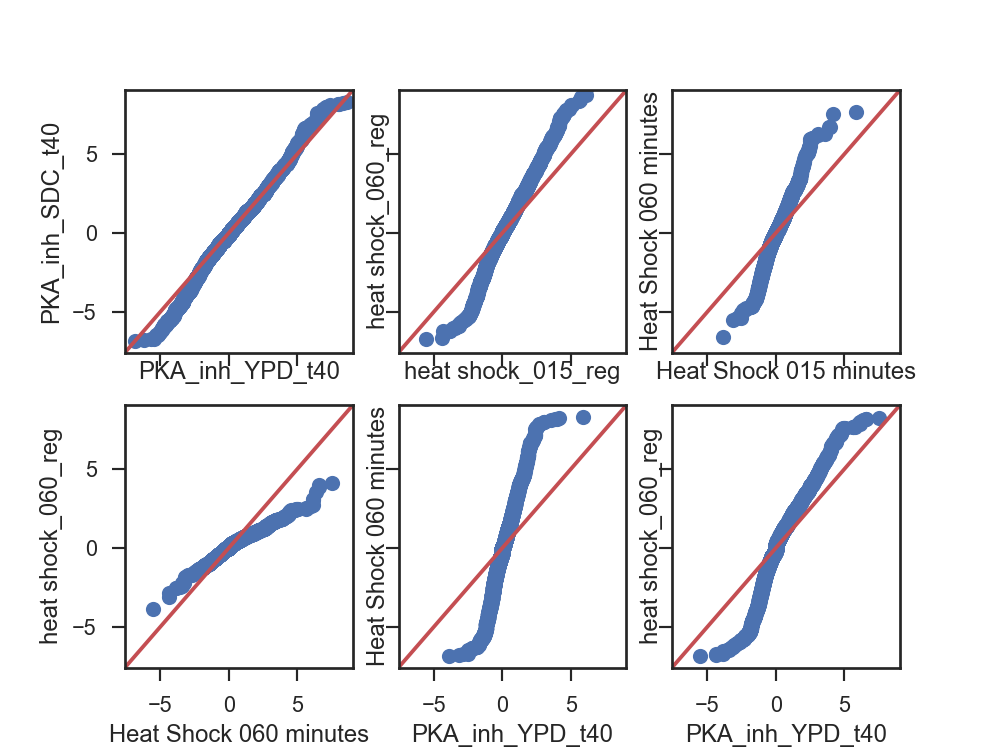

Axes(0.125,0.53;0.227941x0.35)
Axes(0.398529,0.53;0.227941x0.35)
Axes(0.672059,0.53;0.227941x0.35)
Axes(0.125,0.11;0.227941x0.35)
Axes(0.398529,0.11;0.227941x0.35)
Axes(0.672059,0.11;0.227941x0.35)


In [36]:
#qq plot without NA of 

# two RNA seq experiments against each other

fig, axarr = plt.subplots(2,3, sharex = True, sharey = True)

columns_list = [['PKA_inh_YPD_t40', 'PKA_inh_SDC_t40'],
                ['heat shock_015_reg','heat shock_060_reg'], 
                ['Heat Shock 015 minutes','Heat Shock 060 minutes'], 
                ['Heat Shock 060 minutes','heat shock_060_reg'], 
                ['PKA_inh_YPD_t40', 'Heat Shock 060 minutes'], 
                ['PKA_inh_YPD_t40', 'heat shock_060_reg']]
                

for ind, columns in enumerate(columns_list): 
    ax = axarr.flatten()[ind]
    print(ax)
    data_dict = {}
    for column in columns: 
        data = compiled_exp_data[column]
        data_dropna = data.dropna()
        data_nafill = data.fillna(0)
        data_dict[column] = data_nafill

    stats_graph.qqplot_2samples(data_dict[columns[0]], data_dict[columns[1]],xlabel=columns[0], ylabel = columns[1], line = '45', ax=ax)
# mean = data_dropna.mean()
# std = data_dropna.std()
# mean, std = stats.norm.fit(data_nafill)






#stats_graph.gofplots.qqplot_2samples(data1, data2, xlabel=None, ylabel=None, line=None, ax=None)[source]


# two microarray experiments against each other

# RNA seq v.s. microarray

In [ ]:
#qq plot without NA of RNA seq, Gasch, Regev v.s. distro

<IPython.core.display.Javascript object>


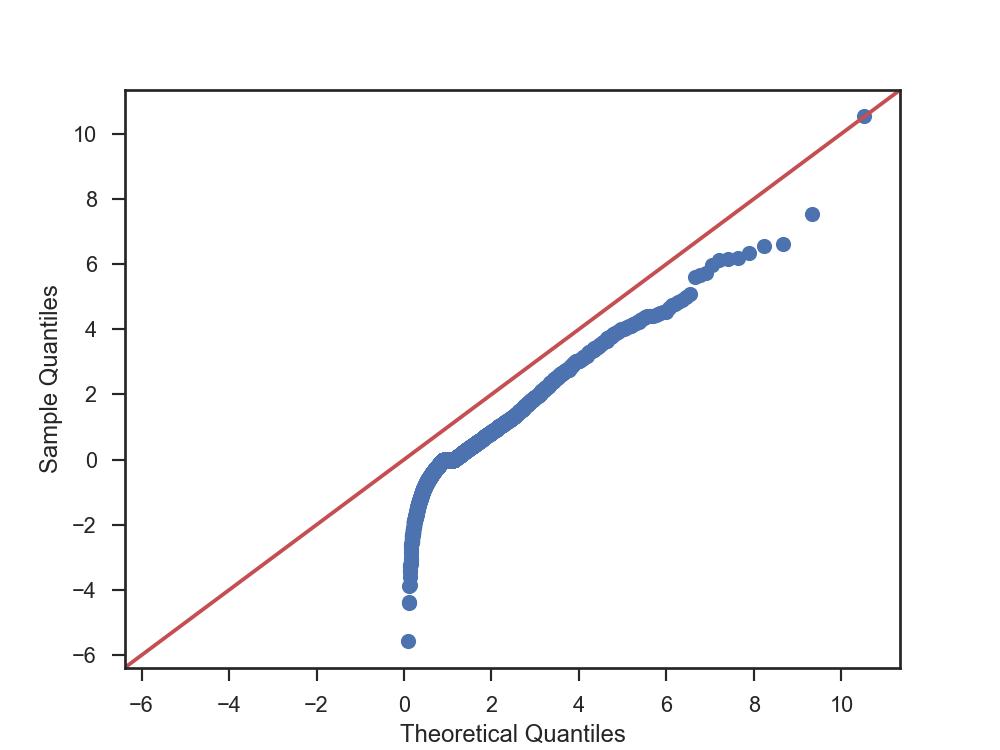

<IPython.core.display.Javascript object>


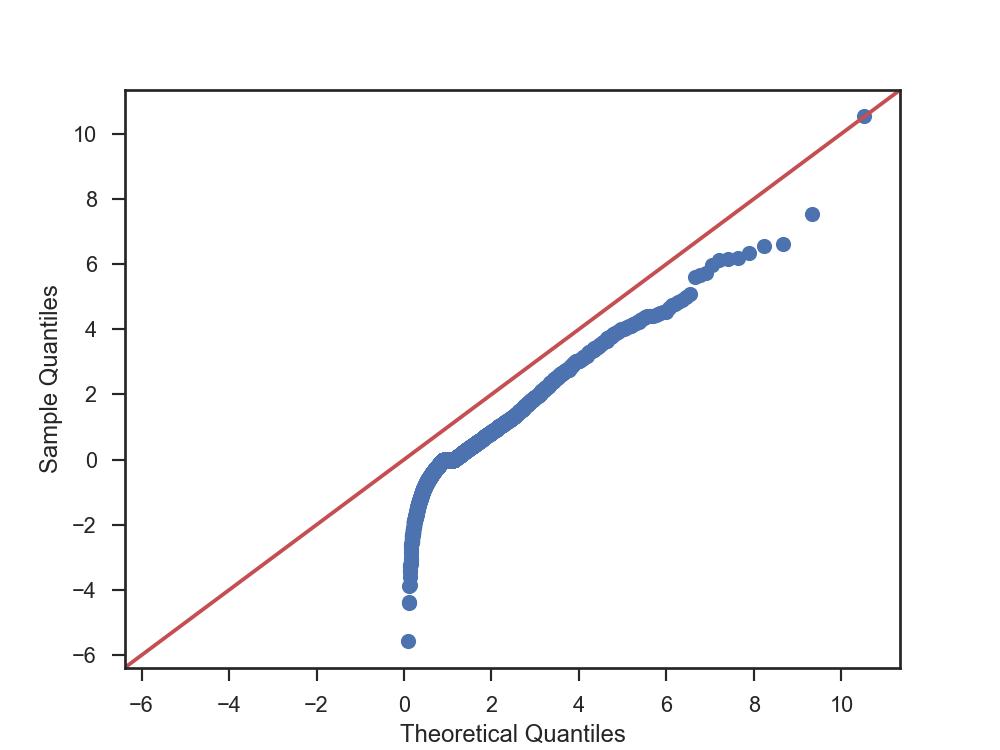

In [49]:
#Histogram/qq plot without NANa for my RNA seq, Gasch and Regev. 

# datasets_to_plot = plt.hist(compiled_exp_data['heat shock_045_reg'].fillna(0),bins=40)

# fig, axarr = plt.subplot()

column = 'heat shock_060_reg'
data = compiled_exp_data[column]
data_dropna = data.dropna()
data_nafill = data.fillna(0)
# mean = data_dropna.mean()
# std = data_dropna.std()
#mean, std = stats.norm.fit(data_nafill)
#fit = stats.cauchy.fit(data_nafill)
# calculate shapiro statistic to check normality 
#stats.shapiro(data_nafill)
#stats.probplot(data_nafill, dist='norm', sparams=(mean,std), plot = plt)
stats_graph.qqplot(data_nafill, dist=stats.lognorm, distargs=[0.65], line='45')

This distribution seems fat tailed and skewed a bit to the right from a normal distribution.  

In [5]:
#Check columns for normality.   Shift and scale based on mean and std 
#(should find a more accurate distribution, and then use that shift/scale parameter)

data_columns = compiled_exp_data.columns
data_columns = data_columns.drop('sc_genename')

means = []
stds = []
shapiro = []

#should put columns into groups from experiments in a series before trying to standardize them

compiled_exp_data_centered = compiled_exp_data.copy()

for column in data_columns: 
    data = compiled_exp_data[column]
    data_dropna = data.dropna()
    data_nafill = data.fillna(0)
    mean = data_dropna.mean()
    std = data_dropna.std()
    means.append(mean)
    stds.append(std)
    shapiro.append(stats.shapiro(data_nafill)[0])
    data_shift = (data-mean)/std
    compiled_exp_data_centered[column] = data_shift
column_stats = pd.DataFrame({'mean': means, 'std': stds, 'shapiro_stat':shapiro}, index = data_columns)

compiled_exp_data_centered
# Save in a dataframe. 



C:\Users\heine\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1326: UserWarning:

p-value may not be accurate for N > 5000.



,sc_genename,PKA_inh_YPD_t40,PKA_inh_SDC_t40,Heat Shock 005 minutes,Heat Shock 015 minutes,Heat Shock 030 minutes,Heat Shock 060 minutes,"heat shock 17 to 37, 20 minutes","heat shock 21 to 37, 20 minutes","heat shock 25 to 37, 20 minutes",...,heat shock_045_reg,heat shock_060_reg,hydrogen peroxide_005_reg,hydrogen peroxide_015_reg,hydrogen peroxide_030_reg,hydrogen peroxide_060_reg,glucose_Aerobic_vs_Anaerobic,nitrogen_Aerobic_vs_Anaerobic,sulfur_Aerobic_vs_Anaerobic,phosphorus_Aerobic_vs_Anaerobic
0,YPL223C,4.208159,3.838395,1.628992,2.038921,2.820080,2.941118,2.272055,1.193974,1.180609,...,1.611470,0.650604,0.742453,0.769703,2.126340,2.253088,6.084110,-2.131492,5.366267,0.586597
1,YMR175W,4.194649,4.015016,0.872657,0.886764,1.226326,0.585256,2.528557,0.253774,0.420588,...,1.255421,0.922468,-1.282219,0.037207,0.131017,1.072923,4.865431,-2.530987,-1.481594,-0.132039
2,YBR072W,4.009976,2.867769,4.276165,4.567983,5.066545,2.594996,3.041561,2.693817,1.992789,...,5.878593,10.154225,-1.860154,0.970885,7.658244,5.295773,3.278936,-0.581456,0.690451,1.628529
3,YML128C,3.912232,2.863214,2.829986,3.862739,4.477205,2.561501,3.651619,3.619093,3.512832,...,3.449010,3.469403,0.387697,0.391009,3.670459,2.641262,3.191285,0.596957,-0.161593,0.950191
4,YMR169C,4.167372,3.870137,0.772921,1.871006,1.568524,0.869969,2.195798,1.626764,1.664936,...,2.967965,1.728970,-0.758369,-0.809078,3.649376,2.807556,1.560111,-0.378390,-0.153394,-0.100940
5,YGR248W,3.688666,3.260979,3.702680,3.831739,4.287095,3.281658,4.837074,4.193660,4.488937,...,4.113144,5.416089,0.315465,-0.386940,4.530927,3.416976,3.329772,2.867677,1.576733,3.550939
6,YGR256W,3.662523,3.718239,0.814478,2.044087,3.054549,2.634074,2.493895,2.343107,2.059850,...,3.179045,2.721523,0.734905,0.554161,1.550592,1.997681,3.696903,-0.980619,-1.499431,0.984400
7,YHR087W,3.419085,2.484303,5.992463,5.169894,4.749696,3.225831,4.227015,4.917465,4.399523,...,4.772684,4.156682,0.781150,4.921253,7.275989,4.160517,1.778839,-0.956729,-0.715861,1.194445
8,YNR034W-A,3.682764,3.020340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.088092,2.583691,0.523478,4.908473,7.404995,4.427861,-0.608596,-1.260996,-2.355504,-2.411435
9,YMR174C,3.327728,3.102810,1.641459,1.480926,1.993103,1.467308,1.239115,1.589455,1.463754,...,3.060464,3.197226,1.429720,1.839922,2.754360,3.418310,2.766024,0.760869,-0.314078,1.047634


In [6]:
#remove all columns that have NANs for my data. 
compiled_exp_data_nanrm = compiled_exp_data[~compiled_exp_data['PKA_inh_YPD_t40'].isna()]

#remove all columns that are filled with NANs 
external_data_columns = data_columns[2:]
ind_to_remove = []
for ind, row in compiled_exp_data_nanrm.iterrows():
    #compiled_exp_data[compiled_exp_data['sc_genename']=='YNR034W-A']
    N_nas = (sum(row[external_data_columns].isna().values))
    if N_nas == len(external_data_columns):
        ind_to_remove.append(ind)
compiled_exp_data_nanrm = compiled_exp_data_nanrm.drop(ind_to_remove)

In [174]:
#conditions with lower correlation
[data_columns[ind] for ind, val in enumerate(corr_mat[0]) if val>0.2]

['PKA_inh_YPD_t40',
 'PKA_inh_SDC_t40',
 'Heat Shock 005 minutes',
 'Heat Shock 015 minutes',
 'Heat Shock 030 minutes',
 'Heat Shock 060 minutes',
 'heat shock 17 to 37, 20 minutes',
 'heat shock 21 to 37, 20 minutes',
 'heat shock 25 to 37, 20 minutes',
 'heat shock 29 to 37, 20 minutes',
 'heat shock 33 to 37, 20 minutes',
 'constant 0.32 mM H2O2 (10 min) redo',
 'constant 0.32 mM H2O2 (20 min) redo',
 'constant 0.32 mM H2O2 (30 min) redo',
 'constant 0.32 mM H2O2 (40 min) rescan',
 'constant 0.32 mM H2O2 (50 min) redo',
 'constant 0.32 mM H2O2 (60 min) redo',
 'constant 0.32 mM H2O2 (80 min) redo',
 'constant 0.32 mM H2O2 (100 min) redo',
 'constant 0.32 mM H2O2 (120 min) redo',
 'constant 0.32 mM H2O2 (160 min) redo',
 '1 mM Menadione (20 min) redo',
 '1 mM Menadione (30 min) redo',
 '1mM Menadione (40 min) redo',
 '1 mM Menadione (105 min) redo',
 '1 mM Menadione (120 min)redo',
 'dtt 030 min',
 'dtt 060 min',
 'dtt 120 min',
 'dtt 240 min',
 'dtt 480 min',
 '1.5 mM diamide (5 mi

In [6]:
data_columns = compiled_exp_data.columns
data_columns = data_columns.drop('sc_genename')

In [7]:
data_columns

Index(['PKA_inh_YPD_t40', 'PKA_inh_SDC_t40', 'Heat Shock 005 minutes',
       'Heat Shock 015 minutes', 'Heat Shock 030 minutes',
       'Heat Shock 060 minutes', 'heat shock 17 to 37, 20 minutes',
       'heat shock 21 to 37, 20 minutes', 'heat shock 25 to 37, 20 minutes',
       'heat shock 29 to 37, 20 minutes', 'heat shock 33 to 37, 20 minutes',
       'heat shock 37 to 37, 20 minutes',
       'constant 0.32 mM H2O2 (10 min) redo',
       'constant 0.32 mM H2O2 (20 min) redo',
       'constant 0.32 mM H2O2 (30 min) redo',
       'constant 0.32 mM H2O2 (40 min) rescan',
       'constant 0.32 mM H2O2 (50 min) redo',
       'constant 0.32 mM H2O2 (60 min) redo',
       'constant 0.32 mM H2O2 (80 min) redo',
       'constant 0.32 mM H2O2 (100 min) redo',
       'constant 0.32 mM H2O2 (120 min) redo',
       'constant 0.32 mM H2O2 (160 min) redo', '1 mM Menadione (10 min)redo',
       '1 mM Menadione (20 min) redo', '1 mM Menadione (30 min) redo',
       '1mM Menadione (40 min) redo', '

In [7]:
data_columns = compiled_exp_data.columns
data_columns = data_columns.drop('sc_genename')

xgene = 'CIT1'
ygene = 'CIT2'
xorf = io_library.SC_orf_lookup_by_name([xgene])[0]
yorf = io_library.SC_orf_lookup_by_name([ygene])[0]


trace1 = pygo.Scatter(
    x = compiled_exp_data_centered[compiled_exp_data_centered['sc_genename']==xorf].loc[:,data_columns].values[0],
    y = compiled_exp_data_centered[compiled_exp_data_centered['sc_genename']==yorf].loc[:,data_columns].values[0],
    text = data_columns,
    mode = 'markers',
    marker = {#'opacity': 0.5, 
              'color': corr_mat[0],
              'size' : 10
             },
    name = xgene + ' vs ' + 'ygene'
)


data = [trace1] 

layout = pygo.Layout(
    xaxis= {
        #"range":[-2, 20],
        "title": xgene
    },
    yaxis= {
        #"range":[-2, 20],
        "title": ygene
    }
)


fig = pygo.Figure(data=data, layout = layout)
py.iplot(fig, filename='paralog_pair_all_conditions_' + xgene + '_' + ygene)

In [14]:
#My data
#other time
#SDC v.s. YPD



#Keep only columns that have conditions




#external PKA inhibition data
#Oshea
oshea_SC_PKA_data = io_library.load_oshea_NMPP1_data()
#Pincus
sc_nmpp1_solis = io_library.load_solis_NMPP1_data('WT')





,ORF,Gene,Heat 0' (A),Heat 0' (B),Heat 15',Heat 30',Heat 45',Heat 60',Heat 120',Acid 0' (A),...,NaCl 30',NaCl 45',NaCl 60',NaCl 120',Sorbitol 0',Sorbitol 15',Sorbitol 30',Sorbitol 45',Sorbitol 90',Sorbitol 120'
0,YAL001C,TFC3,126.0,114.6,127.9,208.2,178.4,85.6,59.3,211.5,...,319.9,191.2,204.8,281.4,194.0,175.4,293.3,280.9,267.7,256.0
1,YAL002W,VPS8,54.0,42.0,70.2,112.9,151.7,106.8,117.8,85.0,...,561.5,714.8,414.1,110.1,353.0,202.2,603.3,381.3,442.3,244.6
2,YAL003W,EFB1,9651.0,7004.0,7530.4,7286.2,7129.0,7351.7,6468.4,11827.0,...,9861.5,6583.2,8363.7,6866.0,15465.0,10136.0,6710.1,8835.1,14018.7,14375.8
3,YAL004W,YAL004W,30.0,33.6,101.3,158.6,54.7,35.9,120.3,37.1,...,653.5,296.6,329.1,212.9,222.0,143.1,160.5,293.1,250.2,136.8
4,YAL005C,SSA1,1816.0,1394.8,4185.5,6146.8,4823.2,4233.3,5565.6,2778.0,...,20417.3,32081.5,41586.3,27077.4,29035.0,25524.7,34268.1,32182.6,22050.5,20653.5
5,YAL007C,ERP2,406.0,318.5,585.6,870.9,1098.9,593.8,686.7,549.5,...,622.9,286.8,486.9,416.0,647.0,248.4,271.2,266.0,483.0,682.1
6,YAL008W,YAL008W,82.0,94.7,457.7,436.9,470.0,304.7,472.9,237.7,...,743.3,123.8,332.2,93.0,239.0,68.3,127.3,150.6,119.9,189.7
7,YAL009W,SPO7,112.0,77.2,215.9,138.2,221.3,221.9,192.6,174.4,...,1399.1,1068.9,1204.3,753.6,1127.0,913.1,1053.5,1000.1,1035.8,999.3
8,YAL010C,MDM10,77.0,63.4,120.5,82.7,124.3,129.8,176.3,133.0,...,237.0,136.9,224.5,20.0,102.0,110.8,86.7,69.2,152.5,93.3
9,YAL011W,YAL011W,224.0,126.0,227.0,308.5,177.7,223.7,199.1,198.4,...,90.5,20.0,95.6,29.4,98.0,59.1,20.0,20.0,34.9,91.2


In [ ]:
#Load Pronk Data

#Load Lai Data
#Anoxia
#reoxygenation
#Ant A

#Bendjilali - time course RNA seq anoxia

#Rintala shifting oxygen only.  


In [ ]:
#If I want to do rlog: 
fname_rlog_data = data_processing_dir + '20170817_klscpka/20170817_klscpka_avg_rlog_' + spec + '.csv'
rlog_data[spec] = pd.read_csv(fname_rlog_data,index_col = 0)
fname_raw_data = data_processing_dir + '20170817_klscpka/20170817_klscpka_avg_counts_' + spec + '.csv'
raw_data[spec] = pd.read_csv(fname_raw_data,index_col = 0)

# GOIs in regev data

In [18]:
#First load SC condition data (see above)
condition_names = condition_arrays_SC.columns[1:]

In [51]:
#Load goi_data
goi_data = pd.read_csv(data_processing_dir + os.path.normpath('20170817_klscpka/goi_data.csv'), index_col=0)
goi_data

,SC_common_name,sc_genename,log2FoldChange_SC,raw_AS_noNMPP1_YPD_t40_mean_SC,raw_AS_yesNMPP1_YPD_t40_mean_SC,kl_genename,log2FoldChange_KL,raw_AS_noNMPP1_YPD_t40_mean_KL,raw_AS_yesNMPP1_YPD_t40_mean_KL,category
3966,NTH2,YBR001C,2.869520,2.136703,3.128899,KLLA0E17271g,2.100226,3.049119,3.840772,metabolic
3967,NTH1,YDR001C,2.815195,1.265725,2.226595,KLLA0E17271g,2.100226,3.049119,3.840772,metabolic
3968,GLK1,YCL040W,4.160390,1.791886,3.224448,KLLA0C01155g,2.178913,2.557021,3.350059,metabolic
3969,EMI2,YDR516C,2.464130,3.271367,4.148126,KLLA0C01155g,2.178913,2.557021,3.350059,metabolic
3972,SKT5,YBL061C,-1.806729,2.460149,2.056057,KLLA0E20263g,-0.380750,2.462343,2.466842,metabolic
3973,SHC1,YER096W,3.793451,1.471903,2.754438,KLLA0E20263g,-0.380750,2.462343,2.466842,metabolic
3978,GND2,YGR256W,7.143522,1.412570,3.676099,KLLA0A09339g,0.394234,3.570254,3.789341,metabolic
3979,GND1,YHR183W,-1.190240,2.855015,2.639284,KLLA0A09339g,0.394234,3.570254,3.789341,metabolic
3994,LPD1,YFL018C,1.016738,3.100750,3.545507,KLLA0D11154g,-0.817035,2.686856,2.538857,metabolic
3995,IRC15,YPL017C,3.049381,0.638741,1.593980,KLLA0D11154g,-0.817035,2.686856,2.538857,metabolic


In [52]:
goi_data_SC_arrays = pd.merge(goi_data,condition_arrays_SC, left_on='sc_genename',right_index = True, how = 'left')


# fig3, ax3 = plt.subplots()
# #ax3= sns.heatmap(kl_stress_nmpp1_data_filt_reorder)
# # ax3 = plt.imshow(kl_stress_nmpp1_data_filt_reorder.as_matrix(), cmap='RdBu', vmin=z_min, vmax=z_max,
# #            extent=[x.min(), x.max(), y.min(), y.max()],
# #            interpolation='nearest', origin='lower')
# ax3 = plt.imshow(-sc_stress_nmpp1_data_reorder.as_matrix(), interpolation="nearest", aspect = 'auto', cmap = 'RdBu',vmin = -6, vmax = 6)

# sns.heatmap(corr)


In [64]:
goi_data_SC_arrays[goi_data_SC_arrays['SC_common_name'].isin(['CIT1','CIT2','YHR033W','PRO1'])]

,SC_common_name,sc_genename,log2FoldChange_SC,raw_AS_noNMPP1_YPD_t40_mean_SC,raw_AS_yesNMPP1_YPD_t40_mean_SC,kl_genename,log2FoldChange_KL,raw_AS_noNMPP1_YPD_t40_mean_KL,raw_AS_yesNMPP1_YPD_t40_mean_KL,category,...,NaCl_060,heat shock_005,heat shock_015,heat shock_030,heat shock_045,heat shock_060,hydrogen peroxide_005,hydrogen peroxide_015,hydrogen peroxide_030,hydrogen peroxide_060
4364,CIT2,YCR005C,-2.464709,2.127879,1.524889,KLLA0F12760g,0.581082,1.966862,2.261104,metabolic,...,0.067841,1.600056,2.890930,-0.725532,0.100272,-1.477646,-0.151265,-0.558669,1.435718,0.898509
4365,CIT1,YNR001C,2.403591,1.737902,2.627134,KLLA0F12760g,0.581082,1.966862,2.261104,metabolic,...,2.537716,1.986048,3.683551,2.983019,3.879069,1.434727,0.252256,0.121861,1.179648,1.919018
4780,PRO1,YDR300C,-5.167378,2.381026,1.009593,KLLA0C10296g,-1.249849,2.798976,2.510343,metabolic,...,-1.609407,-0.300475,-1.989919,-1.494370,-2.168474,-0.165783,-0.047591,-0.004693,-0.125193,-1.045169
4781,YHR033W,YHR033W,0.487044,2.029217,2.303109,KLLA0C10296g,-1.249849,2.798976,2.510343,metabolic,...,7.483065,2.716356,4.297017,2.255776,4.026759,0.393423,0.158055,0.147141,-0.255230,1.833584


In [63]:
#Visualize with a heatmap
goi_data_SC_arrays_sorted = goi_data_SC_arrays.sort_values(by='log2FoldChange_SC')
gene_labels = goi_data_SC_arrays_sorted['SC_common_name']
fc_values = goi_data_SC_arrays_sorted.loc[:,['log2FoldChange_SC'] + list(condition_names) ]



trace = pygo.Heatmap(z = np.array(fc_values),
                   x= list(fc_values.columns),
                   y= list(gene_labels)
                   )

# trace2 = pygo.Heatmap(z = np.array(joint_topology_values).transpose(),
#                    text = np.array(joint_topology_text).transpose(),
#                    x=joint_topology_column_labels,
#                    y= gene_labels, 
#                    hoverinfo = 'x+y+text',
#                    colorscale = 'Electric',
#                    showscale = False)

# trace3 = pygo.Heatmap(z = np.array(topology_values).transpose(),
#                       text = np.array(topology_text).transpose(),
#                    x=topology_column_labels,
#                    y= gene_labels,
#                    colorscale = 'Blackbody',
#                    hoverinfo = 'x+y+text',
#                    showscale = False)


# fig = pytools.make_subplots(rows=1, cols=3)

# fig.append_trace(trace1, 1, 1)
# fig.append_trace(trace2, 1, 2)
# fig.append_trace(trace3, 1, 3)

# #fig['layout'].update(height=600, width=600, title='i <3 subplots')

# # layout = pygo.Layout(
# #     yaxis = {'title': 'Low Paralog / High Paralog'}
# # )


py.iplot([trace], filename='goi_heatmap')